<h1>Transfer Learning</h1> 

Modern object recognition models have millions of parameters and can take weeks to fully train. Transfer learning is a technique that shortcuts a lot of this work by taking a fully-trained model for a set of categories like ImageNet, and retrains from the existing weights for new classes. For more information on the approach you can see this paper on [Decaf](https://arxiv.org/pdf/1310.1531v1.pdf).

In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size... [[read more](http://cs231n.github.io/transfer-learning/)]

In General, it gives **BETTER** result.

In this [Keras Blog tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), with limited training data set. One can acheive a dog/cat recognizer with following accuracy:

 - Custom model: 80% accuracy
 - VGG pre-trained model: 90% accuracy




This notebook just follows the [Building powerful image classification models using very little data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) to see the result using Keras.

There's another tensorflow version you can play with in [Google's Codelab.](https://codelabs.developers.google.com/codelabs/tensorflow-for-poets/#0)



In [1]:
"""
It uses data that can be downloaded at:
https://www.kaggle.com/c/dogs-vs-cats/data
In our setup, we:
- created a data/ folder
- created train/ and validation/ subfolders inside data/
- created cats/ and dogs/ subfolders inside train/ and validation/
- put the cat pictures index 0-999 in data/train/cats
- put the cat pictures index 1000-1399 in data/validation/cats
- put the dogs pictures index 0-999 in data/train/dogs
- put the dog pictures index 1000-1399 in data/validation/dogs
So that we have 1000 training examples for each class, and 400 validation examples for each class.

In summary, this is our directory structure:

```
data/
    train/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
    validation/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
```

"""

import numpy as np
import os, sys
import keras
import argparse

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications

import matplotlib.pyplot as plt



/Users/WeiJay/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
print ("keras.__version__:", keras.__version__)

model_name = 'VGG16' # 'VGG16' or 'RESNET50'
batch_size = 16
epochs = 50
data_dir = '/Users/WeiJay/datasets/dog_cat_2000' # Path to folders of dataset(which contains subdir of train/validation

top_model_weights_path = 'retrain_'+ model_name +'_dogcat2000.h5'
top_model_json_path = 'retrain_' + model_name +'_dogcat2000.json'



keras.__version__: 2.0.8


In [3]:
def dirFileList(dir_path):
    """
    indicate how many category
    """
    my_list = []
    for subdir in os.listdir(dir_path):
        path = os.path.join(dir_path, subdir)
        my_list.extend(os.listdir(path))
    return my_list


def ground_truth_labels(dir_path):
    """
    indicate how many pictures in each category
    """
    labels = []
    for index, subdir in enumerate(os.listdir(dir_path)):
        path = os.path.join(dir_path, subdir)
        labels = np.append(labels, np.array([index] * len(os.listdir(path))))
    return labels.astype(int)


In [4]:
# dimensions of our images.
img_width, img_height = 224, 224

train_data_dir = os.path.join(data_dir, 'train')
validation_data_dir = os.path.join(data_dir, 'validation')

nb_train_samples = len(dirFileList(train_data_dir))
nb_validation_samples = len(dirFileList(validation_data_dir))
nb_class = len(os.listdir(train_data_dir))

print("number of class:", nb_class)
print("number of train:", nb_train_samples)
print("number of validation:", nb_validation_samples)

number of class: 2
number of train: 2000
number of validation: 800


In [5]:
"""save bottleneck features"""
datagen = ImageDataGenerator(rescale=1. / 255)

if model_name == "RESNET50":
    model = applications.resnet50.ResNet50(include_top=False, weights='imagenet')
elif model_name == "VGG16":
    model = applications.VGG16(include_top=False, weights='imagenet')
else:
    raise("Please select a pre-trained model: VGG16 or RESNET50")

# training dataset
generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle=False)

bottleneck_features_train = model.predict_generator(
    generator, nb_train_samples // batch_size)
np.save('bottleneck_features_train_'+ model_name +'.npy', bottleneck_features_train)
print("save training features", bottleneck_features_train.shape)

# validation dataset
generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle=False)
bottleneck_features_validation = model.predict_generator(
    generator, nb_validation_samples // batch_size)
np.save('bottleneck_features_validation_' + model_name  + '.npy', bottleneck_features_validation)
print("saving validation features", bottleneck_features_validation.shape)

Found 2000 images belonging to 2 classes.
save training features (2000, 7, 7, 512)
Found 800 images belonging to 2 classes.
saving validation features (800, 7, 7, 512)


In [9]:
"""
    originally, author adopts binary_crossentropy as loss function.
        - model.add(Dense(1, activation='sigmoid'))
        - model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

    For general purpose, I use categorical_crossentropy as loss function 
        - model.add(Dense(nb_class, activation='softmax'))
        - model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
        
    
    https://stackoverflow.com/questions/44163621/keras-classification-model/44163817
"""

# retrain top model
train_data = np.load('bottleneck_features_train_' + model_name + '.npy')
train_labels = ground_truth_labels(train_data_dir)
train_labels = keras.utils.to_categorical(train_labels, num_classes=nb_class)          # one-hot

validation_data = np.load('bottleneck_features_validation_' + model_name + '.npy')
validation_labels = ground_truth_labels(validation_data_dir)
validation_labels = keras.utils.to_categorical(validation_labels, num_classes=nb_class) # one-hot

model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))
model.add(Dense(nb_class, activation='softmax'))

# see the model struture
model.summary()

# model.compile(optimizer='rmsprop',
              # loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels))

# save model
model_json = model.to_json()
with open(top_model_json_path, "w") as json_file:
    json_file.write(model_json)
model.save_weights(top_model_weights_path)
    
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 514       
Total params: 6,423,298
Trainable params: 6,423,298
Non-trainable params: 0
_________________________________________________________________
Train on 2000 samples, validate on 800 samples
Epoch 1/50
2000/2000 [==============================] - 12s - loss: 1.9759 - acc: 0.7155 - val_loss: 0.3477 - val_acc: 0.8488
Epoch 2/50
2000/2000 [==============================] - 12s - loss: 0.5415 - acc: 0.8250 - 

/Users/WeiJay/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


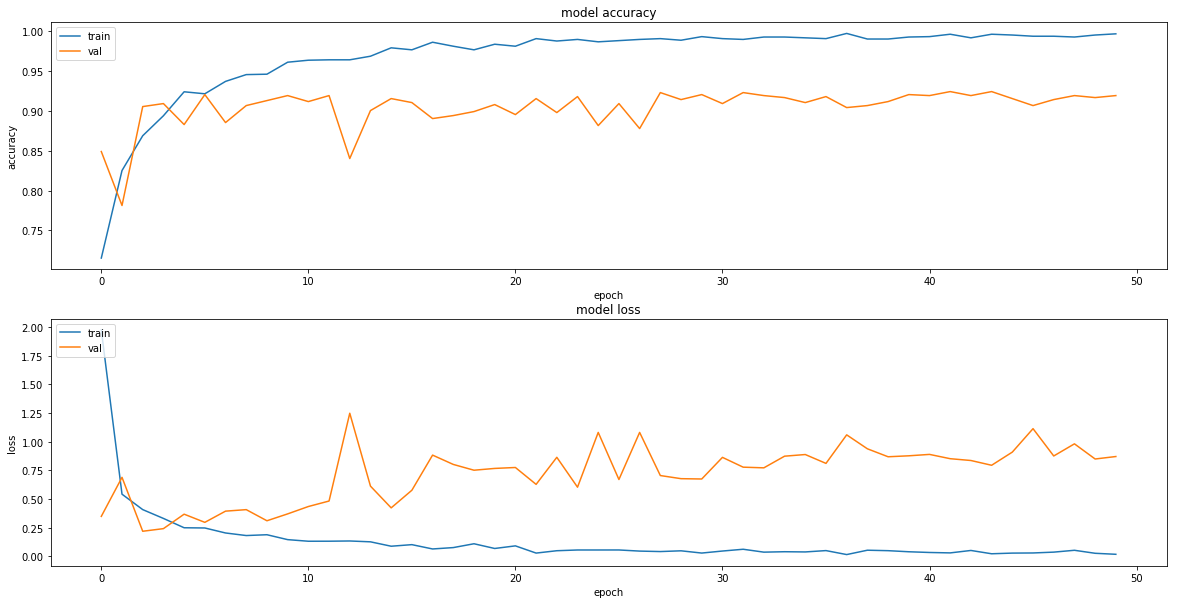

In [10]:
# visualization
plt.figure(1, figsize=(20,10))  
plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'val'], loc='upper left')  

plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'val'], loc='upper left')  
plt.show()